In [22]:
from datasets import load_dataset
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.set_printoptions(threshold=np.inf)
warnings.filterwarnings('ignore')
train = load_dataset("Falah/Alzheimer_MRI",split='train')
test = load_dataset("Falah/Alzheimer_MRI",split='test')

In [23]:
dementia_categories = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

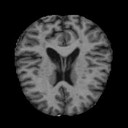

In [24]:
train['image'][0]

In [25]:
category = dementia_categories[train['label'][0]]
print(category)

Non_Demented


# 1-EDA

In [26]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)


# Display the dimensions of the training dataset
print("Training dataset dimensions:", train_df.shape)
print("Testing dataset dimensions:", test_df.shape)

# Convert all images in the 'image' column to NumPy arrays
train_df['image'] = train_df['image'].apply(lambda img: np.array(img))

# Display the dimensions of the first image array
print("Shape of the first image array:", train_df['image'][0].shape)
# Head of Train
train_df.head()

Training dataset dimensions: (5120, 2)
Testing dataset dimensions: (1280, 2)
Shape of the first image array: (128, 128)


,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2


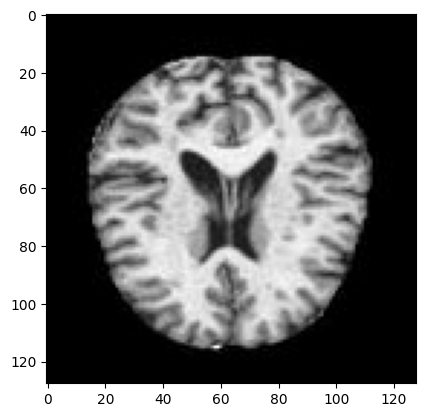

In [27]:
plt.imshow(train_df.image[0],cmap='gray')
plt.show()

In [28]:
# Display data types and check for missing values
print(f"{train_df.dtypes}\n")
print("Missing values in training dataset:\n",train_df.isnull().sum())

image    object
label     int64
dtype: object

Missing values in training dataset:
 image    0
label    0
dtype: int64


In [29]:
# Display descriptive statistics
print(train_df.describe())

             label
count  5120.000000
mean      2.055469
std       0.959244
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       3.000000


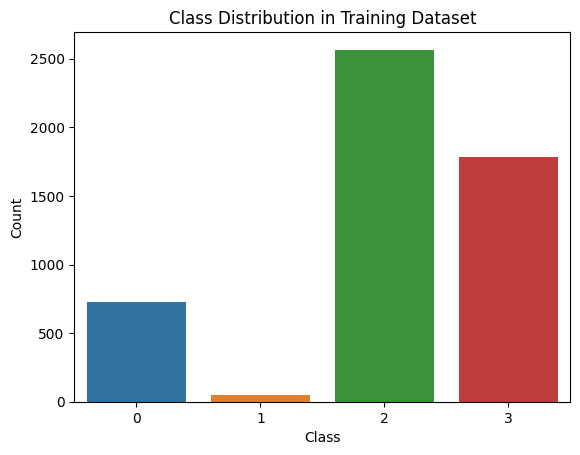

In [30]:
# Visualizing the distribution of classes
sns.countplot(data=train_df, x='label') 
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

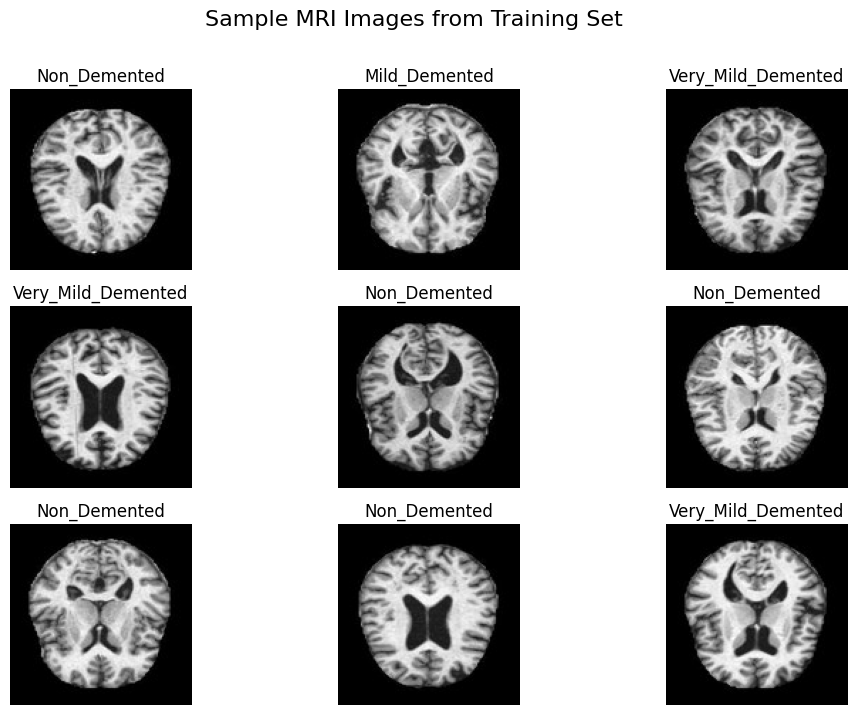

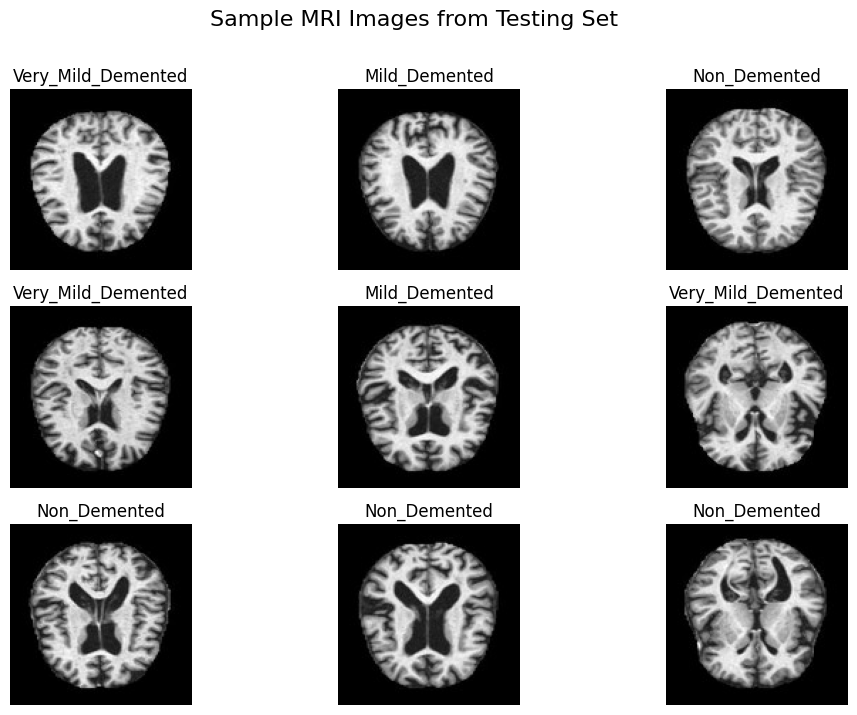

In [31]:
def display_samples(df, title):
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)  # Set the title for the entire figure
    for i in range(9):  # Display 9 samples
        plt.subplot(3, 3, i + 1)
        plt.imshow(df['image'][i], cmap='gray') 
        label = df['label'][i]  
        plt.title(dementia_categories.get(label, 'Unknown'))  # Map numeric label to category
        plt.axis('off')
    plt.show()

# Display samples from the training and testing datasets
display_samples(train_df, "Sample MRI Images from Training Set")
display_samples(test_df, "Sample MRI Images from Testing Set")

# 2-Baseline with Classical ML

In [32]:
# # Prepare the features and target
# X_train = np.array([np.array(img) for img in train_df['image']])
# y_train = train_df['label']
# X_test = np.array([np.array(img) for img in test_df['image']])
# y_test = test_df['label']

# # Flatten the image arrays if needed
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)

# # Initialize and train the logistic regression model
# model = LogisticRegression(max_iter=1000,random_state=42)
# model.fit(X_train, y_train)

# # Make predictions on the training and test sets
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # Calculate accuracy
# train_accuracy = accuracy_score(y_train, y_train_pred)
# test_accuracy = accuracy_score(y_test, y_test_pred)

# print(f"Training Accuracy: {train_accuracy:.2f}")
# print(f"Test Accuracy: {test_accuracy:.2f}")

# 3-Baseline with Convolutional Neural Network

In [33]:
# Custom Dataset class
class AlzheimerDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Convert DataFrame columns to NumPy arrays
train_images = np.array([np.array(img).reshape(128, 128) for img in train_df['image']])
train_labels = np.array(train_df['label'])
test_images = np.array([np.array(img).reshape(128, 128) for img in test_df['image']])
test_labels = np.array(test_df['label'])

# Create datasets and dataloaders
batch_size = 16
train_dataset = AlzheimerDataset(train_images, train_labels)
test_dataset = AlzheimerDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [34]:
import torch.nn as nn
import torch.optim as optim

class CNNSoftmaxModel(nn.Module):
    def __init__(self):
        super(CNNSoftmaxModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)  # Adjust input size based on final feature map size
        self.fc2 = nn.Linear(128, 4)  # Number of classes
    
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x

model = CNNSoftmaxModel()
criterion = nn.CrossEntropyLoss()  # Combines softmax and cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [35]:
import torch.nn.functional as F

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities (optional)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluate the model

print("Test results:")
evaluate_model(model, test_loader)

Epoch 1/10, Loss: 3.4787
Epoch 2/10, Loss: 0.8903
Epoch 3/10, Loss: 0.7729
Epoch 4/10, Loss: 0.6852
Epoch 5/10, Loss: 0.6098
Epoch 6/10, Loss: 0.5293
Epoch 7/10, Loss: 0.4787
Epoch 8/10, Loss: 0.3880
Epoch 9/10, Loss: 0.3773
Epoch 10/10, Loss: 0.3003
Test results:
Accuracy: 0.7984


0.7984375

In [37]:
images = np.array([np.array(img).reshape(128, 128, 1) for img in train_df['image']])
labels = np.array(train_df['label'])
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
# Convert DataFrame columns to NumPy arrays
test_images = np.array([np.array(img).reshape(128, 128, 1) for img in test_df['image']])
test_labels = np.array(test_df['label'])
# Convert to TensorFlow Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# Shuffle, batch, and prefetch
batch_size = 16
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [38]:
def create_cnn_softmax_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define the model
input_shape = (128, 128, 1)
num_classes = 4
model = create_cnn_softmax_model(input_shape, num_classes)

# Train the model
history = model.fit(
    dataset,
    epochs=10
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

Epoch 1/10
 16/320 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3818 - loss: 46.8433

W0000 00:00:1724413803.896416     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4818 - loss: 7.1967
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5787 - loss: 0.8899
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6656 - loss: 0.7536
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7181 - loss: 0.6487
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7898 - loss: 0.5049
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8323 - loss: 0.4039
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8582 - loss: 0.3478
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9131 - loss: 0.2360
Epoch 9/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9338 - loss: 0.1793
Epoch 10/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9290 - loss: 0.1866
52/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8325 - loss: 0.4779

W0000 00:00:1724413829.384892     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8358 - loss: 0.4734
Test accuracy: 0.8383
Test loss: 0.4665
